# Project : Airbnb New User Booking
---


### Abstact :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)

$$DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}$$

$$nDCG_k=\frac{DCG_k}{IDCG_k}$$


- model : Light GBM

- score :  0.88461 (top 11%)

In [1]:
import re
import gc
from datetime import datetime

import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.display import Image 
from IPython.display import display

from scipy.stats import mode
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.metrics import classification_report

import lightgbm as lgb
from lightgbm import plot_importance

import warnings

warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train_users_2.csv")
df_test = pd.read_csv("test_users.csv")
df_countries = pd.read_csv('countries.csv')
df_sessions = pd.read_csv('sessions.csv')
df_age_bkts = pd.read_csv('age_gender_bkts.csv')

In [3]:
df_all = pd.concat([df_train, df_test], axis=0)
train_id = df_train.id
test_id = df_test.id
all_id = df_all.id

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [5]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [7]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [8]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [9]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [10]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


In [11]:
df_countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [12]:
df_age_bkts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


In [13]:
df_age_bkts.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


# country destination

In [14]:
df_train.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

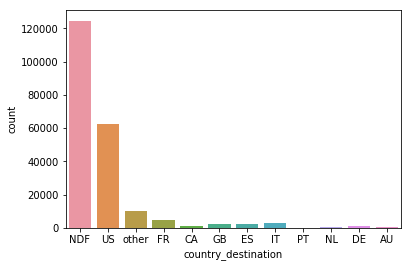

In [15]:
ax = sns.countplot(x=df_train.country_destination , data=df_train)
plt.show()

In [16]:
round(df_train["country_destination"].value_counts() / len(df_train) * 100, 2)

NDF      58.35
US       29.22
other     4.73
FR        2.35
IT        1.33
GB        1.09
ES        1.05
CA        0.67
DE        0.50
NL        0.36
AU        0.25
PT        0.10
Name: country_destination, dtype: float64

# feature engineering

# date time convert

In [17]:
#date account create
df_all["date_account_created"] = pd.to_datetime(df_all["date_account_created"], format = "%Y-%m-%d")

#timestamp first active
df_all["timestamp_first_active"] = pd.to_datetime(df_all["timestamp_first_active"], format="%Y%m%d%H%M%S")

In [18]:
df_all['create_year'] = df_all["date_account_created"].apply(lambda x : x.year)
df_all['create_month'] = df_all["date_account_created"].apply(lambda x : x.month)
df_all['create_day'] = df_all["date_account_created"].apply(lambda x : x.day)

df_all['active_year'] = df_all["timestamp_first_active"].apply(lambda x : x.year)
df_all['active_month'] = df_all["timestamp_first_active"].apply(lambda x : x.month)
df_all['active_day'] = df_all["timestamp_first_active"].apply(lambda x : x.day)

In [19]:
df_all.shape

(275547, 22)

In [20]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,signup_app,signup_flow,signup_method,timestamp_first_active,create_year,create_month,create_day,active_year,active_month,active_day
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,Web,0,facebook,2009-03-19 04:32:55,2010,6,28,2009,3,19
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,Web,0,facebook,2009-05-23 17:48:09,2011,5,25,2009,5,23
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,Web,3,basic,2009-06-09 23:12:47,2010,9,28,2009,6,9
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,Web,0,facebook,2009-10-31 06:01:29,2011,12,5,2009,10,31
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,Web,0,basic,2009-12-08 06:11:05,2010,9,14,2009,12,8


# lagging time

In [21]:
lagging = df_all["timestamp_first_active"] - df_all["date_account_created"]

In [22]:
#lagging time days, log seconds
df_all["lag_days"] = lagging.apply(lambda x : -1 * x.days)
df_all["lag_seconds"] = np.log(lagging.apply(lambda x : x.seconds))

In [23]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,signup_method,timestamp_first_active,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,facebook,2009-03-19 04:32:55,2010,6,28,2009,3,19,466,9.703511
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,facebook,2009-05-23 17:48:09,2011,5,25,2009,5,23,732,11.068028
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,basic,2009-06-09 23:12:47,2010,9,28,2009,6,9,476,11.333404
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,facebook,2009-10-31 06:01:29,2011,12,5,2009,10,31,765,9.984560
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,basic,2009-12-08 06:11:05,2010,9,14,2009,12,8,280,10.010771


# holiday

In [24]:
def get_holidays(year):
    response = requests.get("https://www.timeanddate.com/calendar/custom.html?year="+str(year)+"                                &country=1&cols=3&df=1&hol=25")
    dom = BeautifulSoup(response.content, "html.parser")

    trs = dom.select("table.cht.lpad tr")

    df = pd.DataFrame(columns=["date", "holiday"])
    for tr in trs:
        datestr = tr.select_one("td:nth-of-type(1)").text
        date = datetime.strptime("{} {}".format(year, datestr), '%Y %b %d')
        holiday = tr.select_one("td:nth-of-type(2)").text
        df.loc[len(df)] = {"date" : date, "holiday": 1}
    return df

holiday_ls = []
for year in range(2009, 2015):
    df = get_holidays(year)
    holiday_ls.append(df)
    holiday_df = pd.concat(holiday_ls)

In [25]:
select_date = list(holiday_df["date"].astype("str"))
holiday = df_all.timestamp_first_active.apply(lambda x : str(x.date())).isin(select_date)

df_all["holiday"] = holiday
df_all['holiday'] = 1 * (df_all.holiday == True)

In [26]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,timestamp_first_active,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,2009-03-19 04:32:55,2010,6,28,2009,3,19,466,9.703511,0
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,2009-05-23 17:48:09,2011,5,25,2009,5,23,732,11.068028,0
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,2009-06-09 23:12:47,2010,9,28,2009,6,9,476,11.333404,0
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,2009-10-31 06:01:29,2011,12,5,2009,10,31,765,9.984560,1
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,2009-12-08 06:11:05,2010,9,14,2009,12,8,280,10.010771,0


# weekend

In [27]:
weekday = df_all.filter(items=['id','timestamp_first_active'])
weekday = pd.to_datetime(weekday["timestamp_first_active"], format="%Y-%m-%d")
weekday = weekday.dt.dayofweek

df_all["weekend"] = weekday.apply(lambda x : 1 if x>=5 else 0)

In [28]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,2010,6,28,2009,3,19,466,9.703511,0,0
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,2011,5,25,2009,5,23,732,11.068028,0,1
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,2010,9,28,2009,6,9,476,11.333404,0,0
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,2011,12,5,2009,10,31,765,9.984560,1,1
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,2010,9,14,2009,12,8,280,10.010771,0,0


In [29]:
df_all = df_all.drop("date_account_created" , axis=1)
df_all = df_all.drop("timestamp_first_active" , axis=1)

# faithless sign-in

In [30]:
checklist = (df_all['age'] < 120) & (df_all['gender'] != '-unknown-')

df_all['faithless_sign'] = checklist.apply(lambda x : 0 if x == True else 1)

In [31]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,...,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend,faithless_sign
0,direct,direct,NaN,NDF,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,...,6,28,2009,3,19,466,9.703511,0,0,1
1,seo,google,38.0,NDF,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,...,5,25,2009,5,23,732,11.068028,0,1,0
2,direct,direct,56.0,US,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,...,9,28,2009,6,9,476,11.333404,0,0,0
3,direct,direct,42.0,other,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,...,12,5,2009,10,31,765,9.984560,1,1,0
4,direct,direct,41.0,US,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,...,9,14,2009,12,8,280,10.010771,0,0,1


# null data

In [32]:
df_train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [33]:
df_test.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [34]:
#null data of country_destination is due to concanate train / test data.
df_all.isnull().sum()

affiliate_channel               0
affiliate_provider              0
age                        116866
country_destination         62096
date_first_booking         186639
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
signup_app                      0
signup_flow                     0
signup_method                   0
create_year                     0
create_month                    0
create_day                      0
active_year                     0
active_month                    0
active_day                      0
lag_days                        0
lag_seconds                     0
holiday                         0
weekend                         0
faithless_sign                  0
dtype: int64

In [35]:
print('Train data missing data ratio')
print('date_frist_booking      :',round(df_train.date_first_booking.isnull().sum() / len(df_train) * 100, 2), "%")
print('age                     :',round(df_train.age.isnull().sum() / len(df_train) * 100, 2), "%")
print('first_affiliate_tracked :',round(df_train.first_affiliate_tracked.isnull().sum() / len(df_train) * 100, 2), "%")

Train data missing data ratio
date_frist_booking      : 58.35 %
age                     : 41.22 %
first_affiliate_tracked : 2.84 %


In [36]:
print('Test data missing data ratio')
print('date_frist_booking      :',round(df_test.date_first_booking.isnull().sum() / len(df_test) * 100, 2), "%")
print('age                     :',round(df_test.age.isnull().sum() / len(df_test) * 100, 2), "%")
print('first_affiliate_tracked :',round(df_test.first_affiliate_tracked.isnull().sum() / len(df_test) * 100, 2), "%")

Test data missing data ratio
date_frist_booking      : 100.0 %
age                     : 46.5 %
first_affiliate_tracked : 0.03 %


# drop data_first_booking data

In [37]:
df_all = df_all.drop("date_first_booking", axis=1)

# fill first_affiliate_tracked data by mode

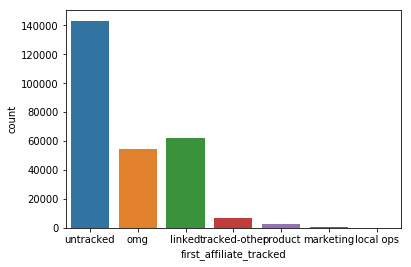

In [38]:
sns.countplot(df_all["first_affiliate_tracked"])
plt.show()

In [39]:
df_all.first_affiliate_tracked.mode()

0    untracked
dtype: object

In [40]:
df_all["first_affiliate_tracked"] = df_all["first_affiliate_tracked"].replace(np.nan, "untracked")

# age data

In [41]:
#more than 200 years old data
#keep this data for faithless-signin
#training data only
len(df_train[df_train['age']>200])

779

In [42]:
df_train[df_train['age']>200].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


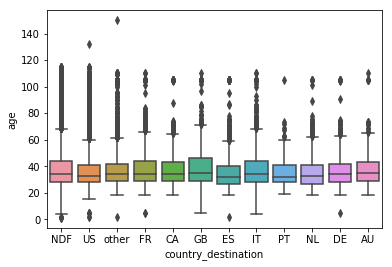

In [43]:
#on each destinations, it has various age distribution. 
#It would be better filling the null age data than dropping the age data. 
age_temp = df_train.copy()
age_temp[ age_temp['age'] > 200 ] = np.nan
sns.boxplot(x=age_temp.country_destination, y=age_temp.age, data=age_temp)
plt.show()

# one-hot encoding before fill age data

In [44]:
df_age = df_all.filter(items = ['age', 'country_destination','id', 'gender'])
df_dummy = df_all.filter(items = ['affiliate_channel', 'affiliate_provider',
                                       'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                       'language', 'signup_app', 'signup_flow', 'signup_method', 
                                       'create_year', 'create_month', 'create_day', 
                                       'active_year', 'active_month', 'active_day', 'lag_days', 'lag_seconds', 
                                       'holiday', 'weekend'])
    
df_dummy = pd.get_dummies(df_dummy)
df_all = pd.concat([df_age, df_dummy], axis=1)

In [45]:
df_all.shape

(275547, 146)

In [46]:
df_all.head()

,age,country_destination,id,gender,signup_flow,create_year,create_month,create_day,active_year,active_month,...,language_tr,language_zh,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo
0,NaN,NDF,gxn3p5htnn,-unknown-,0,2010,6,28,2009,3,...,0,0,0,0,1,0,0,1,0,0
1,38.0,NDF,820tgsjxq7,MALE,0,2011,5,25,2009,5,...,0,0,0,0,1,0,0,1,0,0
2,56.0,US,4ft3gnwmtx,FEMALE,3,2010,9,28,2009,6,...,0,0,0,0,1,0,1,0,0,0
3,42.0,other,bjjt8pjhuk,FEMALE,0,2011,12,5,2009,10,...,0,0,0,0,1,0,0,1,0,0
4,41.0,US,87mebub9p4,-unknown-,0,2010,9,14,2009,12,...,0,0,0,0,1,0,1,0,0,0


# fill age data

In [47]:
#divide train / test by null age data
age_train = df_all[df_all["age"].notnull()].reset_index(drop=True)
age_test = df_all[df_all["age"].isnull()].reset_index(drop=True)

In [48]:
#divide 5 cluster age data
bins = [0, 15, 25, 35, 60, 2015]
labels = ["underage", "tweenty", "thirty", "mid_old", "old"]
cats = pd.cut(age_train['age'], bins, labels=labels)
cats = pd.DataFrame(cats)

In [49]:
age_train_id = age_train.id
age_test_id = age_test.id

age_train = age_train.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
age_test = age_test.drop(['id', 'age', 'country_destination', 'gender'], axis=1)

In [50]:
X = age_train
y = cats

age_train.shape, y.shape, age_test.shape

((158681, 142), (158681, 1), (116866, 142))

In [51]:
#model recall rate is so low, but it gives better cross validation score for final prediction model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    
model_age = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=-1, reg_alpha=0.5, reg_lambda=0.5).fit(X_train, y_train)
pred_age = model_age.predict(X_test)

print(classification_report(y_test, pred_age))

             precision    recall  f1-score   support

    mid_old       0.48      0.38      0.42     11150
        old       0.75      0.00      0.00      2044
     thirty       0.49      0.78      0.60     14036
    tweenty       0.45      0.04      0.07      4490
   underage       0.25      0.06      0.10        17

avg / total       0.50      0.48      0.42     31737



In [52]:
#prediction age
pred_age = model_age.predict(age_test)
pred_age = pd.DataFrame(pred_age, columns=['age'])
pred_age = pd.concat([pred_age, age_test_id], axis=1)
pred_age["age"] = pred_age["age"].replace({'underage':14, "tweenty" : 23, "thirty" : 33, 'mid_old' : 45, 'old' : 70})

#original age
origin_age = y
origin_age = pd.DataFrame(origin_age, columns=['age'])
origin_age = pd.concat([origin_age, age_train_id], axis=1)
origin_age["age"] = origin_age["age"].replace({'underage':14, "tweenty" : 23, "thirty" : 33, 'mid_old' : 45, 'old' : 70})

#concat original age and prediction age
age = pd.concat([origin_age, pred_age], axis=0)
print('age lenght check :', len(age))
age.head()

age lenght check : 275547


,age,id
0,45,820tgsjxq7
1,45,4ft3gnwmtx
2,45,bjjt8pjhuk
3,45,87mebub9p4
4,45,lsw9q7uk0j


In [53]:
df_all = df_all.drop("age" , axis=1)

df_all = pd.merge(df_all, age, on="id", how="left")

In [54]:
df_all.head()

,country_destination,id,gender,signup_flow,create_year,create_month,create_day,active_year,active_month,active_day,...,language_zh,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,age
0,NDF,gxn3p5htnn,-unknown-,0,2010,6,28,2009,3,19,...,0,0,0,1,0,0,1,0,0,33
1,NDF,820tgsjxq7,MALE,0,2011,5,25,2009,5,23,...,0,0,0,1,0,0,1,0,0,45
2,US,4ft3gnwmtx,FEMALE,3,2010,9,28,2009,6,9,...,0,0,0,1,0,1,0,0,0,45
3,other,bjjt8pjhuk,FEMALE,0,2011,12,5,2009,10,31,...,0,0,0,1,0,0,1,0,0,45
4,US,87mebub9p4,-unknown-,0,2010,9,14,2009,12,8,...,0,0,0,1,0,1,0,0,0,45


In [55]:
df_all.isnull().sum()

country_destination                       62096
id                                            0
gender                                        0
signup_flow                                   0
create_year                                   0
create_month                                  0
create_day                                    0
active_year                                   0
active_month                                  0
active_day                                    0
lag_days                                      0
lag_seconds                                   0
holiday                                       0
weekend                                       0
affiliate_channel_api                         0
affiliate_channel_content                     0
affiliate_channel_direct                      0
affiliate_channel_other                       0
affiliate_channel_remarketing                 0
affiliate_channel_sem-brand                   0
affiliate_channel_sem-non-brand         

# filling gender data

In [56]:
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

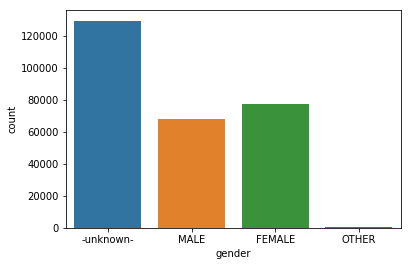

In [57]:
sns.countplot(df_all["gender"])
plt.show()

In [58]:
df_all["gender"] = df_all["gender"].replace(['-unknown-', 'OTHER'], np.nan)

gender_train = df_all[df_all["gender"].notnull()].reset_index()
gender_test = df_all[df_all["gender"].isnull()].reset_index()

In [59]:
y = gender_train.gender

gender_train_id = gender_train.id
gender_test_id = gender_test.id

gender_train = gender_train.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
gender_test = gender_test.drop(['id', 'age', 'country_destination', 'gender'], axis=1)

In [60]:
X = gender_train

gender_train.shape, y.shape, gender_test.shape

((145733, 143), (145733,), (129814, 143))

In [61]:
#model recall rate is so low, but it gives better cross validation score for final prediction model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    
model_age = lgb.LGBMClassifier(n_estimators=500, n_jobs=-1, reg_alpha=1).fit(X_train, y_train)
pred_age = model_age.predict(X_test)

print(classification_report(y_test, pred_age))

             precision    recall  f1-score   support

     FEMALE       0.57      0.68      0.62     15550
       MALE       0.54      0.43      0.48     13597

avg / total       0.56      0.56      0.55     29147



In [62]:
pred_gender = model_age.predict(gender_test)
pred_gender = pd.DataFrame(pred_gender)

In [63]:
#prediction age
pred_gender = model_age.predict(gender_test)
pred_gender = pd.DataFrame(pred_gender, columns=['gender'])
pred_gender = pd.concat([pred_gender, gender_test_id], axis=1)

#original age
origin_gender = y
origin_gender = pd.DataFrame(origin_gender, columns=['gender'])
origin_gender = pd.concat([origin_gender, gender_train_id], axis=1)

#concat original age and prediction age
gender = pd.concat([origin_gender, pred_gender], axis=0)
print('gender lenght check :', len(gender))
gender.head()

gender lenght check : 275547


,gender,id
0,MALE,820tgsjxq7
1,FEMALE,4ft3gnwmtx
2,FEMALE,bjjt8pjhuk
3,FEMALE,lsw9q7uk0j
4,FEMALE,0d01nltbrs


In [64]:
df_all = df_all.drop("gender" , axis=1)

df_all = pd.merge(df_all, gender, on="id", how="left")

In [65]:
df_all.head()

,country_destination,id,signup_flow,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,...,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,age,gender
0,NDF,gxn3p5htnn,0,2010,6,28,2009,3,19,466,...,0,0,1,0,0,1,0,0,33,FEMALE
1,NDF,820tgsjxq7,0,2011,5,25,2009,5,23,732,...,0,0,1,0,0,1,0,0,45,MALE
2,US,4ft3gnwmtx,3,2010,9,28,2009,6,9,476,...,0,0,1,0,1,0,0,0,45,FEMALE
3,other,bjjt8pjhuk,0,2011,12,5,2009,10,31,765,...,0,0,1,0,0,1,0,0,45,FEMALE
4,US,87mebub9p4,0,2010,9,14,2009,12,8,280,...,0,0,1,0,1,0,0,0,45,MALE


In [66]:
df_all.gender.value_counts()

FEMALE    169870
MALE      105677
Name: gender, dtype: int64

# sessions

# action, action_type, action_detail count

In [67]:
def make_merged_sessions():
    
    sessions = df_sessions

    #session elapsed group by sum, mean
    ses = sessions.filter(items=('user_id', 'secs_elapsed'))
     
    print(" groupby aggregation in process...")

        
    ses_groupby_sum = ses.groupby("user_id").agg(np.sum)
    ses_groupby_mean = ses.groupby("user_id").agg(np.mean)
    
    #fill null data with mode value
    sessions["action"] = sessions["action"].fillna("show")
    sessions["action_type"] = sessions["action_type"].fillna("view")
    sessions["action_detail"] = sessions["action_detail"].fillna("view_search_results")
    
    id_groupby = sessions.groupby(sessions["user_id"]).agg(mode)
    
    device_type = []
    action = []
    action_type = []
    action_detail = []
    secs_elapsed = []

    print("id groupby in process...")
    
    for i in range(len(id_groupby.index)):
        device_type.append(id_groupby['device_type'][i][0])
        action.append(id_groupby['action'][i][0])
        action_type.append(id_groupby['action_type'][i][0])
        action_detail.append(id_groupby['action_detail'][i][0])
        secs_elapsed.append(id_groupby['secs_elapsed'][i][0])
    
    id_groupby_df = pd.DataFrame({"id":id_groupby.index ,
                                  "device_type":device_type ,
                                  "action":action,
                                  "action_type":action_type,
                                  "action_detail":action_detail,
                                  "secs_elapsed":secs_elapsed
                                  })
    
     
    print("merge sessions in process...")
    
    merge_ses_groupby = pd.merge(ses_groupby_sum, ses_groupby_mean, left_index=True, right_index=True, how="left")
    merge_ses_groupby = merge_ses_groupby.rename(columns={'secs_elapsed_x': 'secs_sum', 'secs_elapsed_y': 'secs_mean'})
    
    merged_sessions = pd.merge(id_groupby_df, merge_ses_groupby, left_on="id", right_index=True, how="left")
    
    merged_sessions['secs_elapsed'] = merged_sessions['secs_elapsed'].astype(float)
    
    merged_sessions['secs_mean'] = merged_sessions['secs_mean'].fillna(0)
    
    merged_sessions.to_csv("merged_sessions.csv", index=False)

In [68]:
%%time
make_merged_sessions()

 groupby aggregation in process...
id groupby in process...
merge sessions in process...
CPU times: user 4min 27s, sys: 3.85 s, total: 4min 31s
Wall time: 4min 30s


In [69]:
def remove_word():
    
    merged_sessions = pd.read_csv("merged_sessions.csv")

    def remove(word):
        word = re.sub("''", "", word)
        word = re.sub("\W", "", word)
        return word

    merged_sessions["action"] = merged_sessions["action"].apply(remove)
    merged_sessions["action_detail"] = merged_sessions["action_detail"].apply(remove)
    merged_sessions["action_type"] = merged_sessions["action_type"].apply(remove)
    merged_sessions["device_type"] = merged_sessions["device_type"].apply(remove)


    merged_sessions["action_detail"] = merged_sessions["action_detail"].replace({"['-unknown-']":"unknown"})
    merged_sessions["action_type"] = merged_sessions["action_type"].replace({"['-unknown-']":"unknown"})
    merged_sessions["device_type"] = merged_sessions["device_type"].replace({"['-unknown-']":"unknown",                                             "['Android App Unknown Phone/Tablet']": "Androd_unkown_phone"})

    merged_sessions.to_csv("merged_sessions.csv", index=False)

In [70]:
%%time
remove_word()

CPU times: user 2.73 s, sys: 19.8 ms, total: 2.74 s
Wall time: 2.77 s


In [71]:
def sessions_detail_add():

    merged_sessions = pd.read_csv("merged_sessions.csv")
    sessions = df_sessions

    print("groupby count in process...")

    
    tmp = sessions.groupby(["user_id", "action_type"])["device_type"].count().unstack().fillna(0)
    sessions_at = pd.DataFrame(tmp)
    sessions_at.rename(columns = lambda x : "type__" + x, inplace = True)

    tmp = sessions.groupby(["user_id", "action"])["device_type"].count().unstack().fillna(0)
    sessions_a = pd.DataFrame(tmp)
    sessions_a.rename(columns = lambda x : "action__" + x, inplace = True)

    tmp = sessions.groupby(["user_id", "action_detail"])["device_type"].count().unstack().fillna(0)
    sessions_ad = pd.DataFrame(tmp)
    sessions_ad.rename(columns = lambda x : "detail__" + x, inplace = True)

    df_session_info = sessions_at.merge(sessions_a, how = "outer", left_index = True, right_index = True)
    df_session_info = df_session_info.merge(sessions_ad, how = "left", left_index = True, right_index = True)

    df_session_info.drop(["type__-unknown-", "detail__-unknown-"], axis = 1, inplace = True)
    df_session_info = df_session_info.fillna(0)

    print("merge sessions in process...")
    
    last_merged_sessions = pd.merge(merged_sessions, df_session_info, left_on='id', right_index=True, how='left')

    last_merged_sessions.to_csv("merged_sessions.csv", index=False)

In [72]:
%%time
sessions_detail_add()

groupby count in process...
merge sessions in process...
CPU times: user 1min 14s, sys: 5.75 s, total: 1min 20s
Wall time: 1min 21s


In [73]:
merged_sessions = pd.read_csv("merged_sessions.csv")
merged_sessions.head()

,action,action_detail,action_type,device_type,id,secs_elapsed,secs_sum,secs_mean,type__booking_request,type__booking_response,...,detail__view_resolutions,detail__view_search_results,detail__view_security_checks,detail__view_user_real_names,detail__wishlist,detail__wishlist_content_update,detail__wishlist_note,detail__your_listings,detail__your_reservations,detail__your_trips
0,show,view_search_results,view,MacDesktop,00023iyk9l,820.0,867896.0,22253.743590,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0
1,show,view_search_results,view,MacDesktop,0010k6l0om,125.0,586543.0,9460.370968,0.0,0.0,...,0.0,25.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
2,search,view_search_results,click,AndroidAppUnknownPhoneTablet,001wyh0pz8,623.0,282965.0,3179.382022,0.0,0.0,...,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,show,p3,view,unknown,0028jgx1x1,3.0,297010.0,9900.333333,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,show,view_search_results,view,iPhone,002qnbzfs5,1.0,6487080.0,8232.335025,1.0,0.0,...,0.0,202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
merged_sessions.shape

(135483, 530)

In [75]:
gc.collect()

141

In [76]:
df_all = pd.merge(df_all, merged_sessions, on="id", how="left")
df_all.head()

,country_destination,id,signup_flow,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,...,detail__view_resolutions,detail__view_search_results,detail__view_security_checks,detail__view_user_real_names,detail__wishlist,detail__wishlist_content_update,detail__wishlist_note,detail__your_listings,detail__your_reservations,detail__your_trips
0,NDF,gxn3p5htnn,0,2010,6,28,2009,3,19,466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NDF,820tgsjxq7,0,2011,5,25,2009,5,23,732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,4ft3gnwmtx,3,2010,9,28,2009,6,9,476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,other,bjjt8pjhuk,0,2011,12,5,2009,10,31,765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,87mebub9p4,0,2010,9,14,2009,12,8,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df_all.shape

(275547, 675)

In [78]:
gc.collect()

91

# one hot encoding

In [79]:
target = df_all.country_destination[:213451]

In [80]:
df_all = df_all.drop(["country_destination", "id"], axis=1)

In [81]:
df_all = pd.get_dummies(df_all)

In [82]:
gc.collect()

123

# fill null data with imputer

In [83]:
%%time
## impute the missing value using median
from sklearn.preprocessing import Imputer

## impute the missing value using median
impute_list = df_all.columns.tolist()
# impute_list.remove("id")
# impute_list.remove("country_destination")

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

df_all[impute_list] = imp.fit_transform(df_all[impute_list])
# test[impute_list] = imp.fit_transform(test[impute_list])

gc.collect()

CPU times: user 1min 29s, sys: 21.4 s, total: 1min 51s
Wall time: 1min 51s


# split train / test

In [84]:
train = df_all[:213451]
test = df_all[213451:]

In [85]:
train.head()

,signup_flow,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,...,device_type_LinuxDesktop,device_type_MacDesktop,device_type_OperaPhone,device_type_Tablet,device_type_WindowsDesktop,device_type_WindowsPhone,device_type_iPadTablet,device_type_iPhone,device_type_iPodtouch,device_type_unknown
0,0.0,2010.0,6.0,28.0,2009.0,3.0,19.0,466.0,9.703511,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2011.0,5.0,25.0,2009.0,5.0,23.0,732.0,11.068028,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,2010.0,9.0,28.0,2009.0,6.0,9.0,476.0,11.333404,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2011.0,12.0,5.0,2009.0,10.0,31.0,765.0,9.984560,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2010.0,9.0,14.0,2009.0,12.0,8.0,280.0,10.010771,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
train.isnull().sum()

signup_flow                                 0
create_year                                 0
create_month                                0
create_day                                  0
active_year                                 0
active_month                                0
active_day                                  0
lag_days                                    0
lag_seconds                                 0
holiday                                     0
weekend                                     0
affiliate_channel_api                       0
affiliate_channel_content                   0
affiliate_channel_direct                    0
affiliate_channel_other                     0
affiliate_channel_remarketing               0
affiliate_channel_sem-brand                 0
affiliate_channel_sem-non-brand             0
affiliate_channel_seo                       0
affiliate_provider_baidu                    0
affiliate_provider_bing                     0
affiliate_provider_craigslist     

In [87]:
test.head()

,signup_flow,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,...,device_type_LinuxDesktop,device_type_MacDesktop,device_type_OperaPhone,device_type_Tablet,device_type_WindowsDesktop,device_type_WindowsPhone,device_type_iPadTablet,device_type_iPhone,device_type_iPodtouch,device_type_unknown
213451,0.0,2014.0,7.0,1.0,2014.0,7.0,1.0,0.0,1.791759,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
213452,0.0,2014.0,7.0,1.0,2014.0,7.0,1.0,0.0,3.931826,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
213453,0.0,2014.0,7.0,1.0,2014.0,7.0,1.0,0.0,4.682131,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
213454,0.0,2014.0,7.0,1.0,2014.0,7.0,1.0,0.0,4.905275,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
213455,0.0,2014.0,7.0,1.0,2014.0,7.0,1.0,0.0,5.220356,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
test.isnull().sum()

signup_flow                                 0
create_year                                 0
create_month                                0
create_day                                  0
active_year                                 0
active_month                                0
active_day                                  0
lag_days                                    0
lag_seconds                                 0
holiday                                     0
weekend                                     0
affiliate_channel_api                       0
affiliate_channel_content                   0
affiliate_channel_direct                    0
affiliate_channel_other                     0
affiliate_channel_remarketing               0
affiliate_channel_sem-brand                 0
affiliate_channel_sem-non-brand             0
affiliate_channel_seo                       0
affiliate_provider_baidu                    0
affiliate_provider_bing                     0
affiliate_provider_craigslist     

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Columns: 953 entries, signup_flow to device_type_unknown
dtypes: float64(953)
memory usage: 1.5 GB


In [102]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62096 entries, 213451 to 275546
Columns: 953 entries, signup_flow to device_type_unknown
dtypes: float64(953)
memory usage: 452.0 MB


In [117]:
train.shape, test.shape, target.shape

((213451, 953), (62096, 953), (213451,))

In [90]:
gc.collect()

60

# modeling

In [111]:
def submit_kaggle(df_train, df_test, target):
    
    le = LabelEncoder()

    y_train = le.fit_transform(target)
 
    model = lgb.LGBMClassifier(boosting_type= 'gbdt',nthread=3, n_jobs=-1, reg_alpha=1, reg_lambda=0, max_depth=-1, learning_rate=0.1, n_estimators=100)


    print("model fitting starting ...")
    
    model = model.fit(df_train, y_train)
    
    predic_proba = model.predict_proba(df_test)
    
   
    print("model fitting completed ...")

    df_submit = pd.DataFrame(columns=["id", "country"])
    ids = []
    cts = []
    for i in range(len(test_id)):
        idx = test_id.iloc[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(predic_proba[i])[::-1])[:5].tolist()
        
    df_submit["id"] = ids
    df_submit["country"] = cts
    df_submit.to_csv('submission.csv', index = False)
    print("kaggle submission in process ...")
    ! kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f submission.csv -m "Message"
    
    gc.collect()

In [112]:
%%time
submit_kaggle(train, test, target)

model fitting starting ...
model fitting completed ...
kaggle submission in process ...
Successfully submitted to Airbnb New User BookingsCPU times: user 4min 25s, sys: 6.81 s, total: 4min 32s
Wall time: 1min 45s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, nthread=3, num_leaves=31, objective=None,
        random_state=None, reg_alpha=1, reg_lambda=0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

# feature importance

In [115]:
lgb.plot_importance(model, figsize=(50,150))

NameError: name 'model' is not defined

In [ ]:
np.mean(clf5.feature_importances_)

In [ ]:
np.median(clf5.feature_importances_)